# Домашнее задание - линейная регрессия

### Работа с признаками (8 баллов)

Скачайте датасет из материалов к уроку или по ссылке https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv 


Описание признаков:

* Agency — название страхового агентства
* Agency Type — тип страхового агентства
* Distribution Channel — канал продвижения страхового агентства
* Product Name — название страхового продукта
* Duration — длительность поездки (количество дней)
* Destination — направление поездки
* Net Sales — сумма продаж 
* Commission (in value) — комиссия страхового агентства
* Gender — пол застрахованного
* Age — возраст застрахованного

Ответ:
* Claim — потребовалась ли страховая выплата: «да» — 1, «нет» — 0

Обработайте пропущенные значения и примените написанные функции onehot_encode() и minmax_scale().

**Подсказка**: маску для категориальных признаков можно сделать фильтром cat_features_mask = (df.dtypes == "object").values

In [1]:
import numpy as np
import pandas as pd
import os

df = pd.read_csv('travel_insurance.csv')

y = np.where(df['Claim'] == 'Yes', 1, 0)

X = df.drop(columns=['Claim'])

print("Форма X:", X.shape)
print("Форма y:", y.shape)
print("Примеры y:", y[:10])

Форма X: (63326, 10)
Форма y: (63326,)
Примеры y: [0 0 0 0 0 0 0 0 0 0]


Подробный анализ и подготовка датасета часто помогают улучшить качество модели. Ниже представлено несколько идей преобразований. Вы можете применить одно или несколько из этих преобразований (а можете не применять), чтобы помочь будущей модели. 

1. Посмотрите на количественные признаки. Возможно, в некоторых признаках есть выбросы - значения, которые сильно выбиваются. Такие значения полезно удалять. Советуем присмотреться к колонке Duration)

2. Можно заметить, что one hot encoding сильно раздувает количество столбцов. Радикальное решение - можно попробовать выбросить все категориальные признаки из датасета.

3. Если все-таки оставляете категориальные признаки, то подумайте, как уменьшить количество столбцов после one hot encoding. Признаки с большим количеством значений (Duration - 149! разных стран) можно удалить или попробовать сгруппировать некоторые значения.

4. Downsampling. Датасет достаточно большой, разница в классах огромная. Можно уменьшить число наблюдений с частым ответом.

### Рассмотрим детально датасет

In [2]:
print("Типы данных признаков:\n", df.dtypes)

print("\nКоличество уникальных значений:\n", df.nunique())

Типы данных признаков:
 Agency                      str
Agency Type                 str
Distribution Channel        str
Product Name                str
Claim                       str
Duration                  int64
Destination                 str
Net Sales               float64
Commision (in value)    float64
Gender                      str
Age                       int64
dtype: object

Количество уникальных значений:
 Agency                    16
Agency Type                2
Distribution Channel       2
Product Name              26
Claim                      2
Duration                 455
Destination              149
Net Sales               1139
Commision (in value)    1035
Gender                     2
Age                       89
dtype: int64


### Посмотрим на пропуски

In [3]:
miss = df.isnull().sum()
miss_percent = (miss/ len(df)) * 100
miss_table = pd.DataFrame({'Missing': miss, 'Percent': miss_percent})
print(miss_table)

                      Missing    Percent
Agency                      0   0.000000
Agency Type                 0   0.000000
Distribution Channel        0   0.000000
Product Name                0   0.000000
Claim                       0   0.000000
Duration                    0   0.000000
Destination                 0   0.000000
Net Sales                   0   0.000000
Commision (in value)        0   0.000000
Gender                  45107  71.229827
Age                         0   0.000000


## Посмотрим на числовые признаки

In [4]:
numeric_cols = ['Duration', 'Age', 'Net Sales', 'Commision (in value)']

print(df[numeric_cols].describe())

           Duration           Age     Net Sales  Commision (in value)
count  63326.000000  63326.000000  63326.000000          63326.000000
mean      49.317074     39.969981     40.702018              9.809992
std      101.791566     14.017010     48.845637             19.804388
min       -2.000000      0.000000   -389.000000              0.000000
25%        9.000000     35.000000     18.000000              0.000000
50%       22.000000     36.000000     26.530000              0.000000
75%       53.000000     43.000000     48.000000             11.550000
max     4881.000000    118.000000    810.000000            283.500000


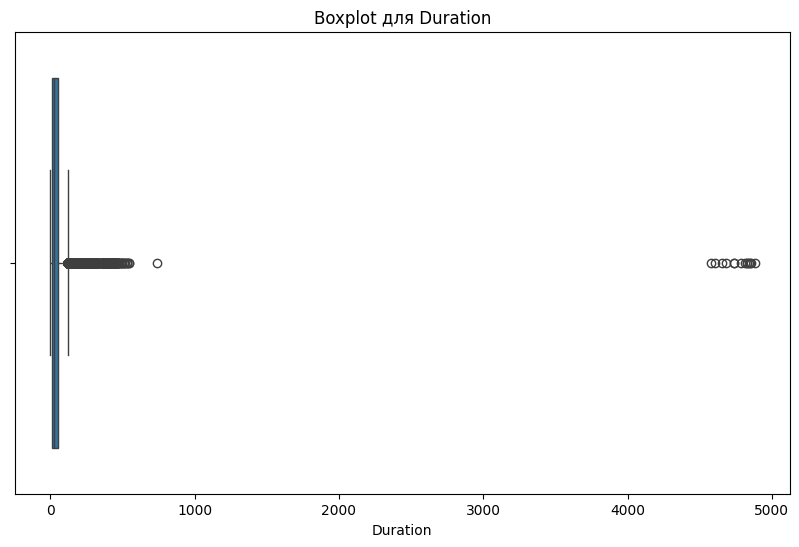

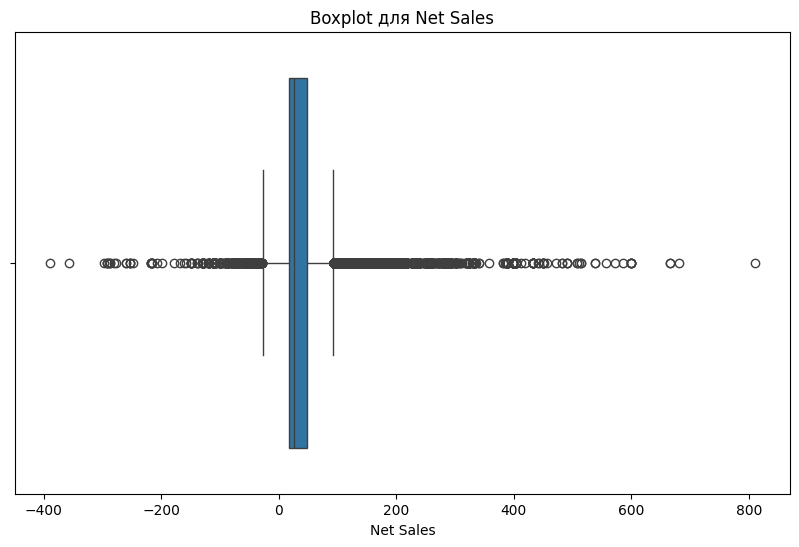

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = (10, 6)

sns.boxplot(x=df['Duration'])
plt.title("Boxplot для Duration")
plt.show()


sns.boxplot(x=df['Net Sales'])
plt.title("Boxplot для Net Sales")
plt.show()


### Посмотрим на графики выше в другом представлении

In [6]:
quantiles = df['Duration'].quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])
print(quantiles)

0.00      -2.0
0.01       1.0
0.05       3.0
0.10       5.0
0.25       9.0
0.50      22.0
0.75      53.0
0.90     109.0
0.95     190.0
0.99     374.0
1.00    4881.0
Name: Duration, dtype: float64


### Мини-вывод: 

Есть серьезный скос в правую часть по duration, скорее всего обрежем часть датасета с выбросами

In [7]:
df['Net Sales'].quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])

0.00   -389.0000
0.01    -12.0000
0.05      4.8825
0.10     10.0000
0.25     18.0000
0.50     26.5300
0.75     48.0000
0.90     80.0000
0.95    112.0000
0.99    252.8500
1.00    810.0000
Name: Net Sales, dtype: float64

### Мини-вывод 2:

Есть отрацительные значения, ради простоты мы их отбросим также, как и хвост. Как мне кажется здесь не нужно пытаться интерпретировать слишком высокие и отрицательные значения, их проще убрать. 

In [8]:
df['Commision (in value)'].quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])

0.00      0.00
0.01      0.00
0.05      0.00
0.10      0.00
0.25      0.00
0.50      0.00
0.75     11.55
0.90     29.70
0.95     51.13
0.99     89.10
1.00    283.50
Name: Commision (in value), dtype: float64

## Вывод по числовым признакам:

#### Duration

- сильно скошен
- есть отрицательные значения

**будем много чистить**

#### Net Sales

- есть отрицательные значения

**Для простоты выбросы будем удалять**

#### Comission

- 50% нули

#### Age

- нет пропусков
- есть странный пункт: максимальный возраст 118, также есть нули

 ## Анализ категориальных признаков

In [9]:
cat_cols = ['Agency', 'Agency Type', 'Distribution Channel',
            'Product Name', 'Destination', 'Gender']

for col in cat_cols:
    print(f"\n===== {col} =====")
    print(df[col].value_counts(dropna=False).head(10))


===== Agency =====
Agency
EPX    35119
CWT     8580
C2B     8267
JZI     6329
SSI     1056
JWT      749
RAB      725
LWC      689
TST      528
KML      392
Name: count, dtype: int64

===== Agency Type =====
Agency Type
Travel Agency    45869
Airlines         17457
Name: count, dtype: int64

===== Distribution Channel =====
Distribution Channel
Online     62219
Offline     1107
Name: count, dtype: int64

===== Product Name =====
Product Name
Cancellation Plan                  18630
2 way Comprehensive Plan           13158
Rental Vehicle Excess Insurance     8580
Basic Plan                          5469
Bronze Plan                         4049
1 way Comprehensive Plan            3331
Value Plan                          2715
Silver Plan                         2249
Annual Silver Plan                  1423
Ticket Protector                    1056
Name: count, dtype: int64

===== Destination =====
Destination
SINGAPORE        13255
MALAYSIA          5930
THAILAND          5894
CHINA       

### Посмотрим на страны

In [10]:
print("Количество уникальных стран:", df['Destination'].nunique())
print("\nТоп-15 стран:")
print(df['Destination'].value_counts().head(15))

print("\nСколько стран встречаются менее 100 раз:")
print((df['Destination'].value_counts() < 100).sum())

Количество уникальных стран: 149

Топ-15 стран:
Destination
SINGAPORE                    13255
MALAYSIA                      5930
THAILAND                      5894
CHINA                         4796
AUSTRALIA                     3694
INDONESIA                     3452
UNITED STATES                 2530
PHILIPPINES                   2490
HONG KONG                     2411
INDIA                         2251
JAPAN                         2061
VIET NAM                      1669
KOREA, REPUBLIC OF            1479
UNITED KINGDOM                1309
TAIWAN, PROVINCE OF CHINA     1090
Name: count, dtype: int64

Сколько стран встречаются менее 100 раз:
110


### Посмотрим на product name

In [11]:
print("Количество уникальных продуктов:", df['Product Name'].nunique())

print("\nТоп-10 продуктов:")
print(df['Product Name'].value_counts().head(10))

Количество уникальных продуктов: 26

Топ-10 продуктов:
Product Name
Cancellation Plan                  18630
2 way Comprehensive Plan           13158
Rental Vehicle Excess Insurance     8580
Basic Plan                          5469
Bronze Plan                         4049
1 way Comprehensive Plan            3331
Value Plan                          2715
Silver Plan                         2249
Annual Silver Plan                  1423
Ticket Protector                    1056
Name: count, dtype: int64


## Выводы по категориальным признакам:

#### Agency

16 уникальных значений, есть дисбаланс (один из признаков 55%), OHE в принципе не сильно уложнит матрицу

#### Agency Type

Бинарный признак, 100% используем как есть

#### Distribution channel

Бинарный признак, но 98% - онлайн, скорее всего не будем использовать

#### Product name

26 уникальных значений, будем использовать OHE, значения которые встречаются редко объединим в категорию other

#### Destination

149 уникальных значений, при этом 110 стран встречаются редко, редкие страны будем группировать для OHE

#### Gender

Бинарный признак, 71% пропусков, использовать не будем

## Итог:

будем использовать следующие признаки:

Duration: очистка + нормализация
Age: очистка + нормализация
Net sales: очистка + нормализация
Commision: нормализация
Agency: OHE
Agency type: binary OHE 
Product name: OHE + редкие в other
Destination: OHE + редкие в other

Заметим, что дальше в OHE будем использовать true/false вместо 0/1 для признаков. С одной стороны это не очень правильно, но с другой стороны так удобнее читать надписи

In [12]:
print("Исходное количество строк:", df.shape[0])

df_clean = df.copy()

df_clean = df_clean[(df_clean['Duration'] >= 0) & (df_clean['Duration'] <= 374)]

df_clean = df_clean[(df_clean['Age'] >= 1) & (df_clean['Age'] <= 100)]

df_clean = df_clean[df_clean['Net Sales'] >= 0]

print("Количество строк после очистки числовых признаков:", df_clean.shape[0])

Исходное количество строк: 63326
Количество строк после очистки числовых признаков: 61065


In [13]:
from sklearn.preprocessing import MinMaxScaler

numeric_cols = ['Duration', 'Age', 'Net Sales', 'Commision (in value)']

scaler = MinMaxScaler()

df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

df_clean[numeric_cols].describe()

,Duration,Age,Net Sales,Commision (in value)
count,61065.000000,61065.000000,61065.000000,61065.000000
mean,0.119743,0.433447,0.058333,0.033676
std,0.175720,0.115523,0.063496,0.068817
min,0.000000,0.000000,0.000000,0.000000
25%,0.024064,0.390805,0.026393,0.000000
50%,0.058824,0.402299,0.038123,0.000000
75%,0.136364,0.471264,0.068915,0.039504
max,1.000000,1.000000,1.000000,1.000000


In [14]:
cat_cols = ['Agency', 'Agency Type', 'Product Name', 'Destination']

df_cat = df_clean.copy()

product_counts = df_cat['Product Name'].value_counts()
rare_products = product_counts[product_counts < 500].index
df_cat['Product Name'] = df_cat['Product Name'].replace(rare_products, 'Other')

top_dest = df_cat['Destination'].value_counts().head(15).index
df_cat['Destination'] = df_cat['Destination'].apply(lambda x: x if x in top_dest else 'Other')

df_cat_ohe = pd.get_dummies(df_cat[cat_cols], drop_first=False)

print("Форма категориальных признаков:", df_cat_ohe.shape)
df_cat_ohe.head()

Форма категориальных признаков: (61065, 45)


,Agency_ADM,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,Agency_CWT,Agency_EPX,Agency_JZI,Agency_KML,...,"Destination_KOREA, REPUBLIC OF",Destination_MALAYSIA,Destination_Other,Destination_PHILIPPINES,Destination_SINGAPORE,"Destination_TAIWAN, PROVINCE OF CHINA",Destination_THAILAND,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_VIET NAM
21,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
22,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
23,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
24,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
25,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [15]:
X_numeric = df_clean[numeric_cols].reset_index(drop=True)

X_categorical = df_cat_ohe.reset_index(drop=True)

X_ready = pd.concat([X_numeric, X_categorical], axis=1)

print("Форма итогового X_ready:", X_ready.shape)
X_ready.head()

Форма итогового X_ready: (61065, 49)


,Duration,Age,Net Sales,Commision (in value),Agency_ADM,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,...,"Destination_KOREA, REPUBLIC OF",Destination_MALAYSIA,Destination_Other,Destination_PHILIPPINES,Destination_SINGAPORE,"Destination_TAIWAN, PROVINCE OF CHINA",Destination_THAILAND,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_VIET NAM
0,0.032086,0.494253,0.067669,0.043918,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,0.018717,0.275862,0.025733,0.016707,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,0.032086,0.379310,0.137830,0.089435,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,0.508021,0.287356,0.432185,0.280446,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,0.973262,0.333333,0.570381,0.370110,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [16]:
y = np.where(df_clean['Claim'] == 'Yes', 1, 0)

unique, counts = np.unique(y, return_counts=True)
print("Распределение классов:")
for u, c in zip(unique, counts):
    print(f"{u}: {c} ({c/len(y)*100:.2f}%)")

Распределение классов:
0: 60202 (98.59%)
1: 863 (1.41%)


### Применение линейной регрессии (10 баллов)

Это задача классификации, но её можно решить с помощью линейной регрессии, если округлять предсказанный ответ до целого и выбирать ближайший по значению ответ из множества {0, 1}.

Вынесите признак 'Claim' в вектор ответов и разделите датасет на обучающую и тестовую выборку в соотношении 80 к 20. Зафиксируйте random_state.

**Подсказка:** быстро перевести Yes/No в 1/0 можно так - np.where(df['Claim'] == 'Yes', 1,0)

In [17]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X_ready, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

os.makedirs("processed_data", exist_ok=True)

X_train.to_csv("processed_data/X_train.csv", index=False)
X_test.to_csv("processed_data/X_test.csv", index=False)

np.savetxt("processed_data/y_train.csv", y_train, delimiter=",")
np.savetxt("processed_data/y_test.csv", y_test, delimiter=",")

X_train: (48852, 49)
X_test: (12213, 49)
y_train: (48852,)
y_test: (12213,)


Найдите аналитическое решение для обучающей выборки: обычное и регуляризацией l2. 

In [18]:
import json

X_train_float = X_train.astype(float)

X_train_bias = np.hstack([np.ones((X_train_float.shape[0], 1)), X_train_float.values])

y_train_float = y_train.astype(float)

w = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train_float

print("Форма вектора весов:", w.shape)
print("Первые 10 весов:", w[:10])

weights_list = w.tolist()

os.makedirs("models", exist_ok=True)
with open("models/linreg_weights.json", "w") as f:
    json.dump(weights_list, f)

Форма вектора весов: (50,)
Первые 10 весов: [ 1.15477478e+13  1.34724942e+00 -6.08158565e-01 -6.78042296e+00
 -1.04395104e+00 -1.59195927e+13 -6.01727169e+12 -6.01727169e+12
 -1.59195927e+13 -1.59195927e+13]


In [19]:
lambda_ridge = 1.0

X_train_float = X_train.astype(float)
X_train_bias = np.hstack([np.ones((X_train_float.shape[0], 1)), X_train_float.values])
y_train_float = y_train.astype(float)


n_features = X_train_bias.shape[1]
I = np.eye(n_features)
I[0,0] = 0
w_ridge = np.linalg.inv(X_train_bias.T @ X_train_bias + lambda_ridge * I) @ X_train_bias.T @ y_train_float

os.makedirs("models", exist_ok=True)
with open("models/linreg_ridge_weights.json", "w") as f:
    json.dump(w_ridge.tolist(), f)

Постройте модель LinearRegression, примените к тестовой выборке и посчитайте MSE (можно использовать библиотеку sklearn)

In [20]:
from sklearn.metrics import mean_squared_error

class LinearRegression:
    def __init__(self, lr=0.01, n_iter=1000, lambda_ridge=0.0):
        
        self.lr = lr
        self.n_iter = n_iter
        self.lambda_ridge = lambda_ridge
        self.w = None

    def fit(self, X, y):
        X = X.astype(float)
        y = y.astype(float)
        
        X_bias = np.hstack([np.ones((X.shape[0], 1)), X.values])
        n_samples, n_features = X_bias.shape

        self.w = np.zeros(n_features)
        
        for i in range(self.n_iter):
            y_pred = X_bias @ self.w
            error = y_pred - y
            
            grad = (2/n_samples) * (X_bias.T @ error) + 2 * self.lambda_ridge * np.r_[0, self.w[1:]]
            self.w -= self.lr * grad

    def predict(self, X):
        X = X.astype(float)
        X_bias = np.hstack([np.ones((X.shape[0], 1)), X.values])
        return X_bias @ self.w

    def mse(self, X, y):
        y_pred = self.predict(X)
        return mean_squared_error(y, y_pred)

In [21]:
import itertools

lr_list = [0.001, 0.01, 0.1]
n_iter_list = [500, 1000]
lambda_list = [0.0, 0.1, 1.0]

best_mse = float('inf')
best_params = None
best_weights = None

for lr, n_iter, lambda_ridge in itertools.product(lr_list, n_iter_list, lambda_list):
    model = LinearRegression(lr=lr, n_iter=n_iter, lambda_ridge=lambda_ridge)
    model.fit(X_train, y_train)
    mse_test = model.mse(X_test, y_test)
    print(f"lr={lr}, n_iter={n_iter}, lambda={lambda_ridge} => MSE={mse_test:.6f}")
    
    if mse_test < best_mse:
        best_mse = mse_test
        best_params = {'lr': lr, 'n_iter': n_iter, 'lambda_ridge': lambda_ridge}
        best_weights = model.w.tolist()

os.makedirs("models", exist_ok=True)
with open("models/best_linreg_params.json", "w") as f:
    json.dump(best_params, f)

with open("models/best_linreg_weights.json", "w") as f:
    json.dump(best_weights, f)

print("MSE на тесте:", best_mse)

lr=0.001, n_iter=500, lambda=0.0 => MSE=0.013758
lr=0.001, n_iter=500, lambda=0.1 => MSE=0.013767
lr=0.001, n_iter=500, lambda=1.0 => MSE=0.013831
lr=0.001, n_iter=1000, lambda=0.0 => MSE=0.013651
lr=0.001, n_iter=1000, lambda=0.1 => MSE=0.013668
lr=0.001, n_iter=1000, lambda=1.0 => MSE=0.013785
lr=0.01, n_iter=500, lambda=0.0 => MSE=0.013501
lr=0.01, n_iter=500, lambda=0.1 => MSE=0.013553
lr=0.01, n_iter=500, lambda=1.0 => MSE=0.013762
lr=0.01, n_iter=1000, lambda=0.0 => MSE=0.013457
lr=0.01, n_iter=1000, lambda=0.1 => MSE=0.013537
lr=0.01, n_iter=1000, lambda=1.0 => MSE=0.013761
lr=0.1, n_iter=500, lambda=0.0 => MSE=0.013409
lr=0.1, n_iter=500, lambda=0.1 => MSE=0.013534
lr=0.1, n_iter=500, lambda=1.0 => MSE=0.013761
lr=0.1, n_iter=1000, lambda=0.0 => MSE=0.013406
lr=0.1, n_iter=1000, lambda=0.1 => MSE=0.013534
lr=0.1, n_iter=1000, lambda=1.0 => MSE=0.013761
MSE на тесте: 0.013405782689089334


In [22]:
with open("models/linreg_weights.json", "r") as f:
    w = np.array(json.load(f))

with open("models/linreg_ridge_weights.json", "r") as f:
    w_ridge = np.array(json.load(f))

with open("models/best_linreg_weights.json", "r") as f:
    w_gd = np.array(json.load(f))

X_test_float = X_test.astype(float)
X_test_bias = np.hstack([np.ones((X_test_float.shape[0], 1)), X_test_float.values])

y_pred_analytic = X_test_bias @ w
y_pred_analytic_rounded = np.rint(y_pred_analytic)
mse_analytic = mean_squared_error(y_test, y_pred_analytic_rounded)

y_pred_ridge = X_test_bias @ w_ridge
y_pred_ridge_rounded = np.rint(y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge_rounded)

y_pred_gd = X_test_bias @ w_gd
y_pred_gd_rounded = np.rint(y_pred_gd)
mse_gd = mean_squared_error(y_test, y_pred_gd_rounded)


print("MSE после округления до 0/1:")
print(f"Аналитическая линрегрессия: {mse_analytic:.6f}")
print(f"Ridge аналитическая линрегрессия: {mse_ridge:.6f}")
print(f"Модель на градиентном спуске: {mse_gd:.6f}")

MSE после округления до 0/1:
Аналитическая линрегрессия: 0.221649
Ridge аналитическая линрегрессия: 0.014165
Модель на градиентном спуске: 0.014165


In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


X_test_float = X_test.astype(float)
X_test_bias = np.hstack([np.ones((X_test_float.shape[0], 1)), X_test_float.values])

y_pred_analytic = np.rint(X_test_bias @ w)
y_pred_ridge = np.rint(X_test_bias @ w_ridge)
y_pred_gd = np.rint(X_test_bias @ w_gd)

acc_analytic = accuracy_score(y_test, y_pred_analytic)
acc_ridge = accuracy_score(y_test, y_pred_ridge)
acc_gd = accuracy_score(y_test, y_pred_gd)

cm_analytic = confusion_matrix(y_test, y_pred_analytic)
cm_ridge = confusion_matrix(y_test, y_pred_ridge)
cm_gd = confusion_matrix(y_test, y_pred_gd)

print("Accuracy и Confusion Matrix после округления до 0/1:\n")

print(f"Аналитическая линрегрессия: Accuracy = {acc_analytic:.4f}")
print(cm_analytic, "\n")

print(f"Ridge аналитическая линрегрессия: Accuracy = {acc_ridge:.4f}")
print(cm_ridge, "\n")

print(f"Модель на градиентном спуске: Accuracy = {acc_gd:.4f}")
print(cm_gd)



f1_gd = f1_score(y_test, y_pred_gd, pos_label=1)
print("F1-score модели на градиентном спуске для класса 1:", f1_gd)


Accuracy и Confusion Matrix после округления до 0/1:

Аналитическая линрегрессия: Accuracy = 0.8189
[[   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   1    3    5   49  739 9990 1237   16]
 [   0    0    2    4   43  113   11    0]
 [   0    0    0    0    0    0    0    0]] 

Ridge аналитическая линрегрессия: Accuracy = 0.9858
[[12040     0]
 [  173     0]] 

Модель на градиентном спуске: Accuracy = 0.9858
[[12040     0]
 [  173     0]]
F1-score модели на градиентном спуске для класса 1: 0.0


### Вывод (1 балла)

Обработка датасета лежит выше, там же и ход мыслей.


Я нашел аналитическое решение линейной регрессии с регуляризацией, которое показало довольно высокую точность 0.9858. Дальше я реализовал модель с использованием градиентного спуска и подбором гиперпараметров. Реализованнаяя модель показала схожий результат с аналитическим решением с регуляризацией. Как мне кажется, модель построена нормально, я не уверен что смог выжать прям все. У модели есть проблема: тк датасет несбалансирован, модели проще предсказать класс 0, тк там меньше шансов ошибиться, это доказывает f1-score. Я не стал пытаться решать эту проблему, тк линейная регрессия слабо подходит для классификации. Я решил сосредоточиться на логической регрессии. По идее, логрег будет показывать хуже точность, но он будет чаще угадывать класс 1.

Пожалуйста, посмотрите финальный блок с выводами в самом низу.

## Сравнение с логистической регрессией

Давайте реализуем логистическую регрессию и сравним её с линейной регрессией. Для несбалансированного датасета (класс 1 встречается ~1% случаев) логистическая регрессия должна лучше справляться с предсказанием редкого класса.

In [26]:
class LogisticRegression:
    def __init__(self, lr=0.01, n_iter=1000, lambda_ridge=0.0):
        self.lr = lr
        self.n_iter = n_iter
        self.lambda_ridge = lambda_ridge
        self.w = None
        self.losses = []
    
    def sigmoid(self, z):
        return np.where(z >= 0, 
                       1 / (1 + np.exp(-z)), 
                       np.exp(z) / (1 + np.exp(z)))
    
    def fit(self, X, y, verbose=False):
        X = X.astype(float)
        y = y.astype(float)
        
        X_bias = np.hstack([np.ones((X.shape[0], 1)), X.values])
        n_samples, n_features = X_bias.shape
        
        self.w = np.zeros(n_features)
        
        for i in range(self.n_iter):
            
            z = X_bias @ self.w
            y_pred = self.sigmoid(z)
            
            
            error = y_pred - y
            grad = (1/n_samples) * (X_bias.T @ error) + self.lambda_ridge * np.r_[0, self.w[1:]]
            
            
            self.w -= self.lr * grad
            
            
            if verbose and i % 100 == 0:
                loss = self.binary_cross_entropy(y, y_pred)
                self.losses.append(loss)
                print(f"Iteration {i}: Loss = {loss:.6f}")
    
    def binary_cross_entropy(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def predict_proba(self, X):
        
        X = X.astype(float)
        X_bias = np.hstack([np.ones((X.shape[0], 1)), X.values])
        z = X_bias @ self.w
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

In [37]:
from sklearn.metrics import f1_score, precision_score, recall_score


lr_list = [0.01, 0.05, 0.1]
n_iter_list = [2000, 3000]
lambda_list = [0.0, 0.01, 0.1]

threshold_list = [0.03, 0.04, 0.08, 0.10]

best_f1 = 0
best_params_logreg = None
best_model = None

print("Подбор гиперпараметров для логистической регрессии")
print("Оптимизируем F1-score для класса 1")
print("Используем низкие пороги из-за несбалансированности данных\n")

results = []
total_combinations = len(lr_list) * len(n_iter_list) * len(lambda_list) * len(threshold_list)
current = 0

for lr, n_iter, lambda_ridge, threshold in itertools.product(lr_list, n_iter_list, lambda_list, threshold_list):
    current += 1
    if current % 10 == 0:
        print(f"Прогресс: {current}/{total_combinations}...")
    
    model = LogisticRegression(lr=lr, n_iter=n_iter, lambda_ridge=lambda_ridge)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test, threshold=threshold)
    
    n_pred_1 = np.sum(y_pred == 1)
    if n_pred_1 == 0:
        f1 = 0.0
    else:
        f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    
    results.append({
        'lr': lr,
        'n_iter': n_iter, 
        'lambda': lambda_ridge,
        'threshold': threshold,
        'f1': f1,
        'pred_class_1': n_pred_1
    })
    
    if f1 > best_f1:
        best_f1 = f1
        best_params_logreg = {
            'lr': lr, 
            'n_iter': n_iter, 
            'lambda_ridge': lambda_ridge,
            'threshold': threshold
        }
        best_model = model

print("Топ-10 комбинаций по F1-score:")

results_sorted = sorted(results, key=lambda x: x['f1'], reverse=True)[:10]
for idx, r in enumerate(results_sorted, 1):
    print(f"{idx}. lr={r['lr']}, n_iter={r['n_iter']}, lambda={r['lambda']}, threshold={r['threshold']}")
    print(f"   F1={r['f1']:.4f}, Предсказано класса 1: {r['pred_class_1']}\n")

print(f"ЛУЧШИЕ ПАРАМЕТРЫ: {best_params_logreg}")
print(f"ЛУЧШИЙ F1-SCORE: {best_f1:.4f}")

Подбор гиперпараметров для логистической регрессии
Оптимизируем F1-score для класса 1
Используем низкие пороги из-за несбалансированности данных

Прогресс: 10/72...
Прогресс: 20/72...
Прогресс: 30/72...
Прогресс: 40/72...
Прогресс: 50/72...
Прогресс: 60/72...
Прогресс: 70/72...
Топ-10 комбинаций по F1-score:
1. lr=0.1, n_iter=3000, lambda=0.01, threshold=0.04
   F1=0.1246, Предсказано класса 1: 1384

2. lr=0.1, n_iter=2000, lambda=0.0, threshold=0.04
   F1=0.1239, Предсказано класса 1: 1473

3. lr=0.1, n_iter=3000, lambda=0.0, threshold=0.04
   F1=0.1239, Предсказано класса 1: 1490

4. lr=0.05, n_iter=3000, lambda=0.0, threshold=0.04
   F1=0.1234, Предсказано класса 1: 1431

5. lr=0.1, n_iter=2000, lambda=0.01, threshold=0.04
   F1=0.1234, Предсказано класса 1: 1480

6. lr=0.1, n_iter=3000, lambda=0.01, threshold=0.03
   F1=0.1233, Предсказано класса 1: 1547

7. lr=0.05, n_iter=3000, lambda=0.01, threshold=0.04
   F1=0.1229, Предсказано класса 1: 1487

8. lr=0.1, n_iter=3000, lambda=0.

### Анализ результатов Grid Search

**Что показывают результаты:**
- F1-score = 0.1246 (12%) — очень низкий показатель при ОЧЕНЬ низком пороге: 0.04

Причина низкого качества:
**Экстремальная несбалансированность**: класс 1 составляет ~1% от датасета


In [39]:
print("анализ качества")


n_test = len(y_test)
n_class_1_real = np.sum(y_test == 1)
n_class_0_real = np.sum(y_test == 0)

print(f"\nТестовая выборка:")
print(f"Всего объектов: {n_test}")
print(f"Класс 0: {n_class_0_real} ({n_class_0_real/n_test*100:.2f}%)")
print(f"Класс 1: {n_class_1_real} ({n_class_1_real/n_test*100:.2f}%)")

y_pred_best = best_model.predict(X_test, threshold=best_params_logreg['threshold'])
y_proba_best = best_model.predict_proba(X_test)

n_pred_class_1 = np.sum(y_pred_best == 1)
n_pred_class_0 = np.sum(y_pred_best == 0)

print(f"\nПредсказания лучшей модели (порог {best_params_logreg['threshold']}):")
print(f"Предсказан класс 0: {n_pred_class_0}")
print(f"Предсказан класс 1: {n_pred_class_1}")

cm_best = confusion_matrix(y_test, y_pred_best)
tn, fp, fn, tp = cm_best.ravel()

print(f"\nConfusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

if tp + fp > 0:
    precision = tp / (tp + fp)
else:
    precision = 0

if tp + fn > 0:
    recall = tp / (tp + fn)
else:
    recall = 0

if precision + recall > 0:
    f1 = 2 * (precision * recall) / (precision + recall)
else:
    f1 = 0

print(f"\nМетрики для класса 1:")
print(f"Precision: {precision:.4f} (из {n_pred_class_1} предсказаний класса 1, {tp} правильных)")
print(f"Recall: {recall:.4f} (из {n_class_1_real} реальных объектов класса 1, найдено {tp})")
print(f"F1-score: {f1:.4f}")

print(f"\nИнтерпретация:")
print(f"Модель угадала {tp} из {n_class_1_real} объектов класса 1 ({tp/n_class_1_real*100:.1f}%)")
print(f"Пропустила {fn} объектов класса 1 ({fn/n_class_1_real*100:.1f}%)")

proba_class_0 = y_proba_best[y_test == 0]
proba_class_1 = y_proba_best[y_test == 1]

print(f"\nСтатистика предсказанных вероятностей:")
print(f" Для реальных объектов класса 0: mean={proba_class_0.mean():.4f}, max={proba_class_0.max():.4f}")
print(f" Для реальных объектов класса 1: mean={proba_class_1.mean():.4f}, max={proba_class_1.max():.4f}")
print(f"\n Проблема: даже для реальных объектов класса 1 вероятности низкие")
print("="*70)

анализ качества

Тестовая выборка:
Всего объектов: 12213
Класс 0: 12040 (98.58%)
Класс 1: 173 (1.42%)

Предсказания лучшей модели (порог 0.04):
Предсказан класс 0: 10829
Предсказан класс 1: 1384

Confusion Matrix:
True Negatives: 10753
False Positives: 1287
False Negatives: 76
True Positives: 97

Метрики для класса 1:
Precision: 0.0701 (из 1384 предсказаний класса 1, 97 правильных)
Recall: 0.5607 (из 173 реальных объектов класса 1, найдено 97)
F1-score: 0.1246

Интерпретация:
Модель угадала 97 из 173 объектов класса 1 (56.1%)
Пропустила 76 объектов класса 1 (43.9%)

Статистика предсказанных вероятностей:
 Для реальных объектов класса 0: mean=0.0170, max=0.0495
 Для реальных объектов класса 1: mean=0.0322, max=0.0492

 Проблема: даже для реальных объектов класса 1 вероятности низкие


In [40]:
y_pred_logreg = best_model.predict(X_test, threshold=best_params_logreg['threshold'])

acc_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg, pos_label=1)
precision_logreg = precision_score(y_test, y_pred_logreg, pos_label=1)
recall_logreg = recall_score(y_test, y_pred_logreg, pos_label=1)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

print("сравнение моделей")

print("\n линрег (ручной):")
print(f"Accuracy:  {acc_gd:.4f}")
print(f"F1-score:  {f1_gd:.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gd, pos_label=1):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_gd, pos_label=1):.4f}")
print(f"Confusion Matrix:")
print(f"{cm_gd}")

print("\n логрег:")
print(f"Accuracy: {acc_logreg:.4f}")
print(f"F1-score: {f1_logreg:.4f}")
print(f"Precision: {precision_logreg:.4f}")
print(f"Recall: {recall_logreg:.4f}")
print(f"Confusion Matrix:")
print(f"{cm_logreg}")


print("анализ предсказаний для класса 1:")


tp_linreg = cm_gd[1, 1]
fn_linreg = cm_gd[1, 0]
total_class1 = tp_linreg + fn_linreg

tp_logreg = cm_logreg[1, 1]
fn_logreg = cm_logreg[1, 0]

print(f"\nВсего объектов класса 1 в тестовой выборке: {total_class1}")
print(f"\nЛинейная регрессия:")
print(f"Правильно предсказано класс 1: {tp_linreg} ({tp_linreg/total_class1*100:.1f}%)")
print(f"Пропущено класс 1: {fn_linreg} ({fn_linreg/total_class1*100:.1f}%)")

print(f"\nЛогистическая регрессия:")
print(f"Правильно предсказано класс 1: {tp_logreg} ({tp_logreg/total_class1*100:.1f}%)")
print(f"Пропущено класс 1: {fn_logreg} ({fn_logreg/total_class1*100:.1f}%)")

print(f"\nУлучшение recall для класса 1: {(recall_logreg - recall_score(y_test, y_pred_gd, pos_label=1))*100:.1f}%")

сравнение моделей

 линрег (ручной):
Accuracy:  0.9858
F1-score:  0.0000
Precision: 0.0000
Recall:    0.0000
Confusion Matrix:
[[12040     0]
 [  173     0]]

 логрег:
Accuracy: 0.8884
F1-score: 0.1246
Precision: 0.0701
Recall: 0.5607
Confusion Matrix:
[[10753  1287]
 [   76    97]]
анализ предсказаний для класса 1:

Всего объектов класса 1 в тестовой выборке: 173

Линейная регрессия:
Правильно предсказано класс 1: 0 (0.0%)
Пропущено класс 1: 173 (100.0%)

Логистическая регрессия:
Правильно предсказано класс 1: 97 (56.1%)
Пропущено класс 1: 76 (43.9%)

Улучшение recall для класса 1: 56.1%


/Users/vladimirolejnik/Projects/YML-linreg/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


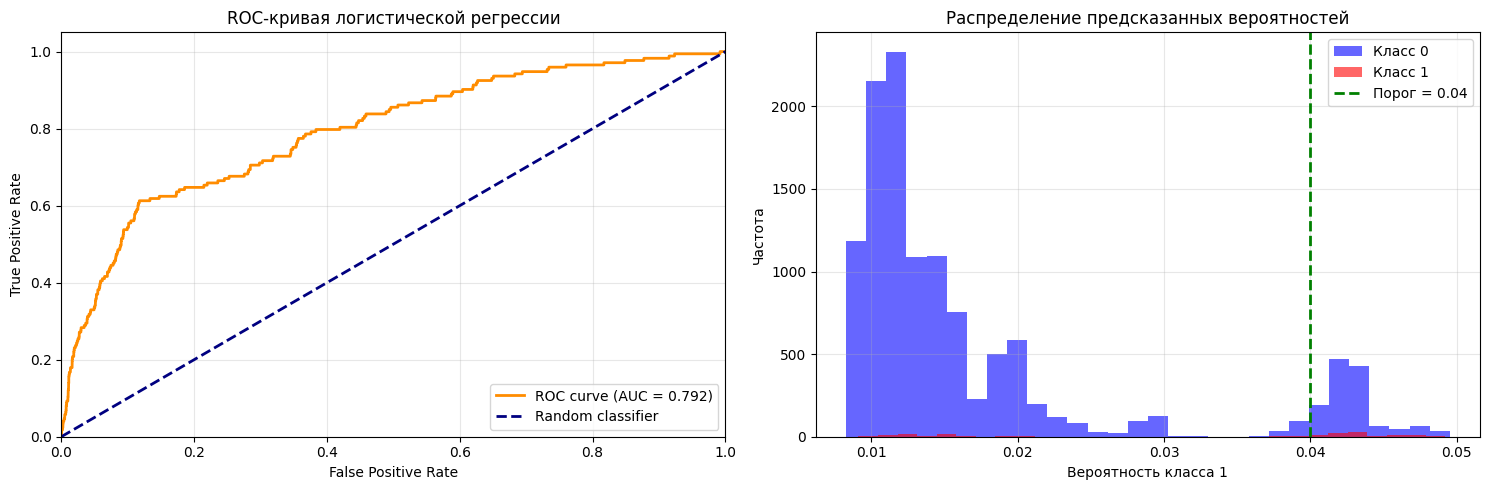

ROC-AUC: 0.7924


In [41]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba_logreg = best_model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_proba_logreg)
roc_auc = roc_auc_score(y_test, y_proba_logreg)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC-кривая логистической регрессии')
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

axes[1].hist(y_proba_logreg[y_test == 0], bins=30, alpha=0.6, label='Класс 0', color='blue')
axes[1].hist(y_proba_logreg[y_test == 1], bins=30, alpha=0.6, label='Класс 1', color='red')
axes[1].axvline(x=best_params_logreg['threshold'], color='green', linestyle='--', 
                linewidth=2, label=f'Порог = {best_params_logreg["threshold"]}')
axes[1].set_xlabel('Вероятность класса 1')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение предсказанных вероятностей')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"ROC-AUC: {roc_auc:.4f}")

In [43]:
with open("models/best_logreg_params.json", "w") as f:
    json.dump(best_params_logreg, f)

with open("models/best_logreg_weights.json", "w") as f:
    json.dump(best_model.w.tolist(), f)

print("Параметры и веса логистической регрессии сохранены в папку models/")
print(f"Лучшие параметры: {best_params_logreg}")

Параметры и веса логистической регрессии сохранены в папку models/
Лучшие параметры: {'lr': 0.1, 'n_iter': 3000, 'lambda_ridge': 0.01, 'threshold': 0.04}


## Финальный вывод:

Возможно я сделал задание не совсем так6 как оно задумывалось, в том плане, что я не довел линрег до конца. Но мне кажется, что для данной задачи класификации больше подходит логрег (исходя из пройденных тем). Возможно, в будущем я попробую решить задачу используя нелинейные модели, наприме catboost или xgboost. Для данного датасета бустинги могут дать еще лучшее решение. 